#####  DNN기반 이진분류 모델 구현
- 데이터 셋 : iris.csv
- 피쳐/속성 : 3개 Sepal.Length, Sepal.Width, Petal.Length, Petal.Width
- 타겟/라벨 : 1개 Setosa와 나머지
- 학습-방법 : 지도학습 > 분류 > 이진분류
- 알고 리즘 : 인공신경망(ANN) -> MLP, DNN : 은닉층이 많은 구성 
- 프레임워크 : Pytorch

[1] 모듈 로딩 및 데이터 준비 <hr>

In [2]:
# 모듈 로딩
# - Model관련
import torch              
import torch.nn as nn              
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader 
import torch.optim as optim    
from torchmetrics.classification import F1Score, BinaryF1Score, BinaryAccuracy
from torchmetrics.classification import BinaryConfusionMatrix
from torchinfo import summary 

#- Data 및 시각화 관련
import pandas as pd 
import matplotlib.pyplot as plt              
from sklearn.preprocessing import * 
from sklearn.model_selection import train_test_split 

In [3]:
# 활용 패키지 버전 체크 ==> 사용자 정의함수로 구현하세요~!!
print(f'Pytorch v.{torch.__version__}')
print(f'Pandas  v.{pd.__version__}')

Pytorch v.2.4.1
Pandas  v.2.0.3


In [4]:
###  데이터 로딩
DATA_FILE='../data/iris.csv' 

### CSV >>> DataFrame
irisDF = pd.read_csv(DATA_FILE)

### 확인
irisDF.head(1)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa


In [5]:
### 타겟 변경 => 정수화 , 클래스 3개 => 2개
irisDF['variety'].unique()

array(['Setosa', 'Versicolor', 'Virginica'], dtype=object)

In [6]:
#-- 클래스 3개 => 2개
irisDF['variety']=(irisDF['variety'] == 'Setosa')
irisDF['variety']=irisDF['variety'].astype('int')

print(f"고유값 : {irisDF['variety'].unique()}")
irisDF.head(1)
print(f"클래스별 데이터 수 : {irisDF['variety'].value_counts()}")

고유값 : [1 0]
클래스별 데이터 수 : variety
0    100
1     50
Name: count, dtype: int64


[2] 모델 클래스 설계 및 정의 <hr>
- 클래스목적 : iris 데이터를 학습 및 추론 목적
- 클래스이름 : IrisBCFModel
- 부모클래스 : nn.Module
- 매개__변수 : 층별 입출력 개수 고정하기때문에 필요 없음!
- 속성__필드 : 
- 기능__역할 : __init__() : 모델 구조 설정 ,  forward() : 순방향 학습 <= 오바라이딩(overriding)
- 클래스구조 
    * 입력층 : 입력  4개(피쳐)      출력    10개 (퍼셉트론/뉴런 10개 존재)
    * 은닉층 : 입력 10개            출력    5개  (퍼셉트론/뉴런 5개 존재)
    * 출력층 : 입력  5개            출력    1개  (퍼셉트론/뉴런 1개 존재 : 2진분류)
- 활성화함수
    * 클래스 형태 ==> nn.MESLoss, nn.ReLU ==> __init__() 메서드 
    * 함수 형태 ==> torch.nn.functional 아래에  ==> forward()메서드

In [8]:
class IrisBCFModel(nn.Module):
    
    # 모델 구조 구성 및 인스턴스 생성 메서드
    def __init__(self):
        super().__init__()
        self.in_layer=nn.Linear(4, 10)
        self.hd_layer=nn.Linear(10, 5)
        self.out_layer=nn.Linear(5, 1)
        
    # 순방향 학습 진행 메서드
    def forward(self, input_data):
        #- 입력층
        y=self.in_layer(input_data)   
        y=F.relu(y)                   
        
        # - 은닉층 : 10개의 숫자 값(>=0)
        y=self.hd_layer(y)            
        y=F.relu(y)                  
        
        #- 출력층 : 5개의 숫자 값 => 이진분류
        return F.sigmoid(self.out_layer(y))         


[3] 데이터셋 클래스 설계 및 정의 <hr>

In [9]:
class IrisDataset(Dataset):
    
    def __init__(self, featureDF, targetDF):
        self.featureDF=featureDF 
        self.targetDF=targetDF
        self.n_rows=featureDF.shape[0]
        self.n_features=featureDF.shape[1]
    
    def __len__(self):
        return self.n_rows
    
    def __getitem__(self, index):
        # 텐서화
        featureTS=torch.FloatTensor(self.featureDF.iloc[index].values)
        targetTS=torch.FloatTensor(self.targetDF.iloc[index].values) 
        
        # 피쳐와 타겟 반환
        return featureTS, targetTS

In [10]:
## [테스트] 데이터셋 인스턴스 생성

# - DataFram에서 피쳐와 타겟 추출
featureDF = irisDF[irisDF.columns[:-1]]   # 2D (150, 3)
targetDF = irisDF[irisDF.columns[-1:]]    # 2D (150, 1)

# - 커스텀데이터셋 인스턴스 생성
irisDS=IrisDataset(featureDF, targetDF)

# - 데이터로더 인스턴스 생성 
irisDL = DataLoader(irisDS)
for feature, label in irisDL: 
    print(feature.shape, label.shape, feature, label)
    break

torch.Size([1, 4]) torch.Size([1, 1]) tensor([[5.1000, 3.5000, 1.4000, 0.2000]]) tensor([[1.]])


[4] 학습 준비 
- 학습_횟수 : EPOCH         <- 처음~끝까지 공부하는 단위
- 배치_크기 : BATCH_SIZE    <- 한번에 학습할 데이터셋 양 
- 위치_지정 : DEVICE    <- 텐서 저장 및 실행 위치 (GPU/CPU)
- 학_습_률 : LR 가중치와 절편 업데이트 시 경사하강법으로 업데이트 간격 설정 0.001~0.1 

In [11]:
### 학습 진행 관련 설정
EPOCH = 1000
BATCH_SIZE = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 0.001

- 인스턴스/객체 : 모델, 데이터셋, 최적화 (, 손실함수, 성능지표)

In [12]:
# 모델 인스턴스
model=IrisBCFModel().to(DEVICE)

In [13]:
# DS과 DL 인스턴스
#- 학습용, 검즈용, 테스트용 데이터 분리
X_train, X_test, y_train, y_test =train_test_split(featureDF, targetDF, random_state=1, stratify=targetDF)
X_train, X_val, y_train, y_val =train_test_split(X_train, y_train, random_state=1, stratify=y_train)

print(f'{X_train.shape} {X_test.shape} {X_val.shape}')
print(f'{y_train.shape} {y_test.shape} {y_val.shape}')
print(f'{y_train.value_counts()} {y_test.value_counts()} {y_val.value_counts()}')
print(f'{type(X_train)} {type(X_test)} {type(X_val)}')

# - 학습용, 검즈용, 테스트용 데이터셋
trainDS=IrisDataset(X_train, y_train)
valDS=IrisDataset(X_val, y_val)
testDS=IrisDataset(X_test, y_test)

# - 학습용 데이터로더 인스턴스
trainDL=DataLoader(trainDS, batch_size=BATCH_SIZE)

(84, 4) (38, 4) (28, 4)
(84, 1) (38, 1) (28, 1)
variety
0          56
1          28
Name: count, dtype: int64 variety
0          25
1          13
Name: count, dtype: int64 variety
0          19
1           9
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


- 최적화, 손실함수 인스턴스 생성

In [14]:
# 최적화 인스턴스 => W,b 텐서 즉, model.parameters() 전달
optimizer=optim.Adam(model.parameters(), lr=LR)

# 손실함수 인스턴스 => 분류 => 이진분류 BinaryCrossEntropyLoss =>  BCELoss 
#                            예측값은 확률값으로 전달 ==> sigmoid() AF 처리 후 전달
crossLoss=nn.BCELoss()

[5] 학습 진행

In [15]:
len(trainDL), trainDL.__len__()

(9, 9)

In [16]:
import math as m 

trainDS.n_rows/BATCH_SIZE, m.ceil(trainDS.n_rows/BATCH_SIZE) , trainDS.featureDF.shape[0]

(8.4, 9, 84)

In [17]:
## 학습의 효과 확인 손실값과 성능평가값 저장 필요
LOSS_HISTORY, SCORE_HISTORY=[[],[]], [[],[]]
CNT=len(trainDL)
print(f'BATCH_CNT => {CNT}')

for epoch in range(EPOCH):
    # 학습 모드로 모델 설정
    model.train()
    
    # 배치 크기 만큼 데이터 로딩해서 학습 진행
    loss_total, score_total=0,0
    for featureTS, targetTS in trainDL:
        
        # 학습 진행
        pre_y=model(featureTS)
        
        # 손실 계산
        loss=crossLoss(pre_y, targetTS)
        loss_total += loss.item()
        
        # 성능평가 계산
        #print(f"[TRAIN]",pre_y, targetTS, sep='\n')
        #score=F1Score(task='binary', zero_division=1.0)(pre_y, targetTS)
        score=BinaryAccuracy()(pre_y, targetTS)
        score_total += score.item()
        #print("[TRAIN - score ]",score.item(), sep='\n')
        
        # 최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # 에포크 당 검증기능
    # 모델 검증 모드 설정
    model.eval()
    with torch.no_grad():
        # 검증 데이터셋
        val_featrueTS=torch.FloatTensor(valDS.featureDF.values)
        val_targetTS=torch.FloatTensor(valDS.targetDF.values)
        
        # 추론/평가
        pre_val=model(val_featrueTS)
    
        # 손실
        loss_val=crossLoss(pre_val, val_targetTS)
        # 성능평가
        #score_val=F1Score(task='binary')(pre_val, val_targetTS)
        score_val=BinaryAccuracy()(pre_y, targetTS)

    #에포크 당 손실값과 성능평가값 저장    
    LOSS_HISTORY[0].append(loss_total/CNT)
    SCORE_HISTORY[0].append(score_total/CNT)
    
    LOSS_HISTORY[1].append(loss_val)
    SCORE_HISTORY[1].append(score_val)
    
    print(f'[{epoch}/{EPOCH}]\n- [TRAIN] LOSS : {LOSS_HISTORY[0][-1]} SCORE : {SCORE_HISTORY[0][-1]}')
    print(f'- [VALID] LOSS : {LOSS_HISTORY[1][-1]} SCORE : {SCORE_HISTORY[1][-1]}')

BATCH_CNT => 9
[0/1000]
- [TRAIN] LOSS : 0.8720496164427863 SCORE : 0.34444444957706666
- [VALID] LOSS : 0.8698257803916931 SCORE : 0.5
[1/1000]
- [TRAIN] LOSS : 0.8370017011960348 SCORE : 0.34444444957706666
- [VALID] LOSS : 0.8348431587219238 SCORE : 0.5
[2/1000]
- [TRAIN] LOSS : 0.8076660699314542 SCORE : 0.34444444957706666
- [VALID] LOSS : 0.8056384921073914 SCORE : 0.5
[3/1000]
- [TRAIN] LOSS : 0.7834965984026591 SCORE : 0.34444444957706666
- [VALID] LOSS : 0.7814687490463257 SCORE : 0.5
[4/1000]
- [TRAIN] LOSS : 0.7634419070349799 SCORE : 0.34444444957706666
- [VALID] LOSS : 0.7612782120704651 SCORE : 0.5
[5/1000]
- [TRAIN] LOSS : 0.7464067935943604 SCORE : 0.34444444957706666
- [VALID] LOSS : 0.7437805533409119 SCORE : 0.5
[6/1000]
- [TRAIN] LOSS : 0.731433649857839 SCORE : 0.34444444957706666
- [VALID] LOSS : 0.728118896484375 SCORE : 0.5
[7/1000]
- [TRAIN] LOSS : 0.7179117732577853 SCORE : 0.34444444957706666
- [VALID] LOSS : 0.7135290503501892 SCORE : 0.5
[8/1000]
- [TRAIN] 

- 학습결과 체크 => 학습와 검증의 Loss 변화, 성능 변화

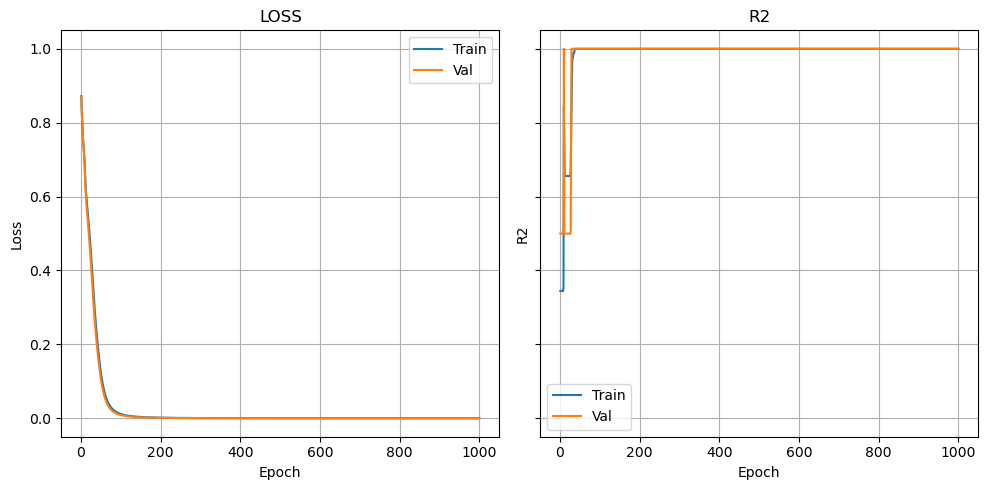

In [18]:
# 학습 후 loss 시각화
import matplotlib.pyplot as plt

fg, axes=plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
axes[0].plot(range(1, EPOCH+1), LOSS_HISTORY[0][:EPOCH], label='Train')
axes[0].plot(range(1, EPOCH+1), LOSS_HISTORY[1][:EPOCH], label='Val')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("LOSS")

axes[1].plot(range(1, EPOCH+1), SCORE_HISTORY[0][:EPOCH], label='Train')
axes[1].plot(range(1, EPOCH+1), SCORE_HISTORY[1][:EPOCH], label='Val')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("R2")
axes[1].set_title("R2")
plt.tight_layout()
plt.show()

[6] 테스트

In [19]:
# 모델 검증 모드 설정
model.eval()
with torch.no_grad():
    # 검증 데이터셋
    test_featrueTS=torch.FloatTensor(testDS.featureDF.values).to(DEVICE)
    test_targetTS=torch.FloatTensor(testDS.targetDF.values).to(DEVICE)
    
    # 추론/평가
    pre_test=model(test_featrueTS)

    # 손실
    loss_test=crossLoss(pre_test, test_targetTS)
    # 성능평가
    #score_val=F1Score(task='binary')(pre_test, val_targetTS)
    score_Test=BinaryAccuracy()(pre_test, test_targetTS)
    
print(f'- [TEST] LOSS : {loss_test.item()} SCORE : {score_Test.item()}')

- [TEST] LOSS : 4.7446183089050464e-06 SCORE : 1.0
